## Importando bibliotecas e validando base de dados

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import re
import string
import nltk
import pickle
import matplotlib.pyplot as plt
%matplotlib inline    

In [2]:
df1 = pd.read_csv("base/base_dados_1.csv", delimiter=",")  # Base por Pelle [2017]
df2 = pd.read_csv("base/base_dados_2.csv", delimiter=";")  # Base por Fortuna [2019]



df = pd.concat([df1, df2], ignore_index=True)

In [3]:
df1.shape

(1242, 2)

In [4]:
df2.shape

(5670, 2)

In [5]:
df.head()

,hatespeech,text
0,yes,Votaram no PEZAO Agora tomem no CZAO
1,no,cuidado com a poupanca pessoal Lembram o que a...
2,no,Sabe o que eu acho engracado os nossos governa...
3,yes,os cariocas tem o que merecem um pessoal que s...
4,no,Podiam retirar dos lucros dos bancos


## Balanceando amostras

In [6]:
Counter(df['hatespeech'])

Counter({'yes': 2202, 'no': 4710})

In [7]:
cut = 2202
df_yes = df[df['hatespeech'] == 'yes'].head(cut)
df_no = df[df['hatespeech'] == 'no'].head(cut)

df_cut=pd.concat([df_yes, df_no])

In [8]:
Counter(df_cut['hatespeech'])

Counter({'yes': 2202, 'no': 2202})

In [9]:
df_cut = df

## Limpando Dados

In [10]:
list_stops_words = []

In [12]:
# O Natural Language Toolkit necessita de bases de dados/bibliotecas que possam categorizar informações em pt-BR.
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('portuguese')
#Objeto que extrai o radical de palavras.
lemmatizer = nltk.stem.RSLPStemmer()
print(stopwords)

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
def clean_text(text):
    text_new = text.lower()
    text_new = text_new.replace('\r\n'," ")
    text_new = re.sub(r'(http|https)\S+', "", text_new)
    text_new = re.sub(r'[@]\w+','',text_new)
    text_new = re.sub(r'[^\w\s]|[_-]|[0-9]','', text_new)
    text_new = text_new.split(" ")
    text_new = [x for x in text_new if x not in stopwords]
    text_new.remove(' ') if ' ' in text_new else None
    return " ".join(text_new)

In [22]:
df_cut['text_clean'] = df['text'].apply(lambda x: clean_text(x))

In [23]:
df_cut.head(10)

,hatespeech,text,text_clean
0,yes,Votaram no PEZAO Agora tomem no CZAO,votaram pezao agora tomem czao
1,no,cuidado com a poupanca pessoal Lembram o que a...,cuidado poupanca pessoal lembram aconteceu epo...
2,no,Sabe o que eu acho engracado os nossos governa...,sabe acho engracado governantes nao pensam co...
3,yes,os cariocas tem o que merecem um pessoal que s...,cariocas merecem pessoal so sabem toma banho s...
4,no,Podiam retirar dos lucros dos bancos,podiam retirar lucros bancos
5,no,CADE O GALVAO PRA NARRAR AGORA FALIIIIUUUUUU...,cade galvao pra narrar agora faliiiiuuuuuuu ...
6,no,Nao e possivel que deputados tenham tantos car...,nao possivel deputados tantos cargos comission...
7,no,Sejam honestos aprovem o projeto original vamo...,honestos aprovem projeto original vamos acabar...
8,no,Nao a pizza anunciada de anistia do caixa Sim...,nao pizza anunciada anistia caixa sim divulga...
9,no,quem ja viu bandidos fazendo leis contra antic...,ja viu bandidos fazendo leis contra anticorrup...


In [24]:
df_cut['text'].shape


(6912,)

In [25]:

X = df_cut['text_clean']
Y = df_cut['hatespeech']
vectorizer = CountVectorizer()
X_vectorizer = vectorizer.fit_transform(X)


x_treino, x_validacao, y_treino, y_validacao = train_test_split(X_vectorizer.toarray(), Y, test_size=0.2, random_state=42)

In [26]:
X[0]

'votaram pezao agora tomem czao'

In [27]:
vectorizer.get_feature_names_out()

array(['aa', 'aaaa', 'aaaaa', ..., 'úteis', 'útero', 'útil'], dtype=object)

In [28]:
X_vectorizer.shape

(6912, 14565)

In [29]:
classificadores = [LogisticRegression(), MultinomialNB(), LinearSVC()]

In [30]:
TOTAL_KFOLDS = 10
metricas = ['accuracy', 'balanced_accuracy', 'roc_auc']
nomes = ['Logistic Regression', 'Multinomial Naive Bayes', 'Linear SVC (SVM)']
modelos = {}
resultados = []
resultados_testes_metricas = {}
resultados_validacao = {}


## Treina modelos

Realizao treinamento e teste baseado em cada classificador, avalia  erro e score baseado nas métricas espacificadas


In [31]:
for i in range(len(classificadores)):
    scores = cross_validate(classificadores[i], x_treino, y_treino, scoring=metricas, cv=TOTAL_KFOLDS)
    resultados_testes_metricas[nomes[i]] = scores
print(resultados_testes_metricas)

{'Logistic Regression': {'fit_time': array([6.31835842, 6.03275871, 5.47732282, 6.24981046, 6.24503016,
       6.06797338, 7.35412216, 7.14133382, 6.83616185, 6.19531274]), 'score_time': array([0.06951308, 0.06050944, 0.05350614, 0.05301046, 0.05428481,
       0.05400801, 0.08853102, 0.08067298, 0.06107569, 0.05835962]), 'test_accuracy': array([0.7323689 , 0.72694394, 0.75768535, 0.75768535, 0.76311031,
       0.74141049, 0.73960217, 0.72875226, 0.74864376, 0.77717391]), 'test_balanced_accuracy': array([0.64477154, 0.64962547, 0.6767191 , 0.67812864, 0.67485735,
       0.65735817, 0.66039046, 0.64217429, 0.65688017, 0.697185  ]), 'test_roc_auc': array([0.74376779, 0.74968539, 0.78963296, 0.75330864, 0.76773818,
       0.76618469, 0.73194814, 0.71599498, 0.76087444, 0.74433696])}, 'Multinomial Naive Bayes': {'fit_time': array([1.83465052, 1.96727705, 2.14233518, 1.86916518, 1.764364  ,
       1.77801108, 1.76296401, 1.82035017, 1.74391794, 1.74651289]), 'score_time': array([0.06634688, 

## Realiza a predição com cada um dos classificadores

A validação Utilizando a base de validação com dados que não estão entre aqueles
#utilizados para treino pelos classificadores. Além disso, armazena os valores de acurácia obtidos
#para cada class.

In [32]:
for i in range(len(classificadores)):
    modelos[nomes[i]] = classificadores[i].fit(x_treino, y_treino)
    results = classificadores[i].predict(x_validacao)
    acuracia = accuracy_score(y_validacao, results)
    resultados_validacao[nomes[i]] = acuracia
    
print(f"Acurácia: {resultados_validacao}")

Acurácia: {'Logistic Regression': 0.737527114967462, 'Multinomial Naive Bayes': 0.7194504699927693, 'Linear SVC (SVM)': 0.7194504699927693}


In [103]:
input_example = 'putos'

input_example = clean_text(input_example)
print (input_example)

input_predict = vectorizer.transform([input_example])
print(input_predict.toarray())

otarios
[[0 0 0 ... 0 0 0]]


In [104]:
input_predict.shape

(1, 14565)

In [105]:
result = modelos['Logistic Regression'].predict(input_predict.toarray())
print(result[0])

no


In [106]:
result = modelos[ 'Multinomial Naive Bayes'].predict(input_predict.toarray())
print(result[0])

no


In [107]:
result = modelos['Linear SVC (SVM)'].predict(input_predict.toarray())
print(result[0])

no


In [38]:
#Cria um gráfico a partir dos parâmetros de abscissas e ordenadas passados como parâmetro e salva num arquivo PNG na raiz do programa.
def mostrarGraficoLinhas(y_linsvc, y_multnvb, y_lreg, x_kfolds, y_values, x_label, y_label):
    figure(num=None, figsize=(8, 6))
    plt.plot(x_kfolds, y_lreg, '.', label='Logistic regression',linestyle='-')  # Recebe dois arrays, um sera do K e outro dos resultados
    plt.plot(x_kfolds, y_multnvb, '.', label='Multinomial Naive Bayes', linestyle='-')
    plt.plot(x_kfolds, y_linsvc, '.', label='LinearSVC', linestyle='-')
    plt.ylim(0, 1)
    plt.yticks(y_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(x_label + " vs. " + y_label)
    plt.legend()
    plt.savefig('teste-' + y_label + '.png')
    plt.show()

In [39]:
resultados_testes_metricas['Logistic Regression']

{'fit_time': array([6.31835842, 6.03275871, 5.47732282, 6.24981046, 6.24503016,
        6.06797338, 7.35412216, 7.14133382, 6.83616185, 6.19531274]),
 'score_time': array([0.06951308, 0.06050944, 0.05350614, 0.05301046, 0.05428481,
        0.05400801, 0.08853102, 0.08067298, 0.06107569, 0.05835962]),
 'test_accuracy': array([0.7323689 , 0.72694394, 0.75768535, 0.75768535, 0.76311031,
        0.74141049, 0.73960217, 0.72875226, 0.74864376, 0.77717391]),
 'test_balanced_accuracy': array([0.64477154, 0.64962547, 0.6767191 , 0.67812864, 0.67485735,
        0.65735817, 0.66039046, 0.64217429, 0.65688017, 0.697185  ]),
 'test_roc_auc': array([0.74376779, 0.74968539, 0.78963296, 0.75330864, 0.76773818,
        0.76618469, 0.73194814, 0.71599498, 0.76087444, 0.74433696])}

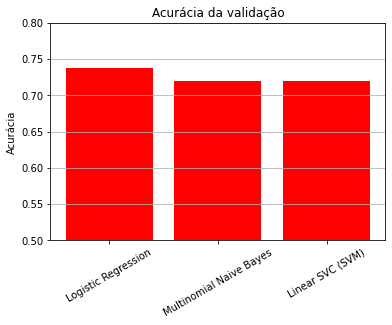

In [40]:
resultados_validacao.values
plt.bar(nomes,resultados_validacao.values(), align='center', color = 'red')
plt.xticks(np.arange(len(nomes)), nomes, rotation=30)
plt.title('Acurácia da validação')
plt.ylabel('Acurácia')
plt.yticks(np.arange(0.5, 0.8, step=0.05))
plt.ylim((0.5,0.8))
plt.grid(axis='y')
plt.savefig('graficos/validacao-acuracia.png')

In [41]:
result_metricas = []
for chave, valor in resultados_testes_metricas.items():
    result_metricas.append(valor['test_' + metricas[i]])

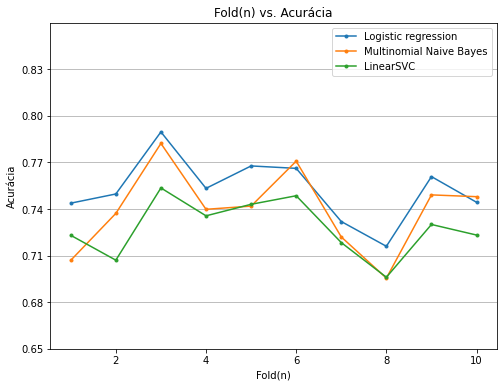

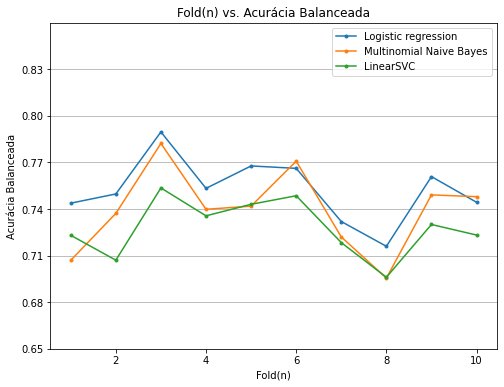

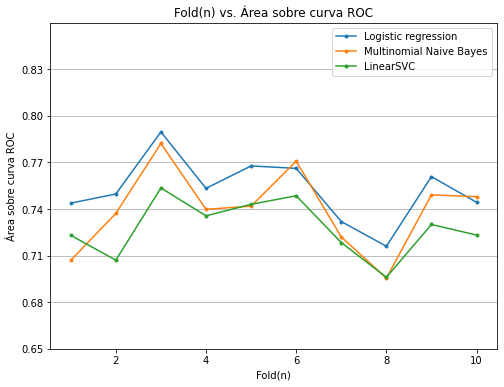

In [42]:
label = ['Acurácia', 'Acurácia Balanceada', 'Área sobre curva ROC']
kfolds = [i+1 for i in range(TOTAL_KFOLDS)]
for i in range(len(metricas)):
    plt.figure(num=None, figsize=(8, 6))
    plt.plot(kfolds, result_metricas[0], '.', label='Logistic regression',linestyle='-')  # Recebe dois arrays, um sera do K e outro dos resultados
    plt.plot(kfolds, result_metricas[1], '.', label='Multinomial Naive Bayes', linestyle='-')
    plt.plot(kfolds, result_metricas[2], '.', label='LinearSVC', linestyle='-')
    plt.ylim(0, 1)
    plt.yticks(np.arange(0.5, 0.85, step=0.03))
    plt.ylim((0.65,0.86))
    plt.xlabel("Fold(n)")
    plt.ylabel(label[i])
    plt.title("Fold(n) vs. " + label[i])
    plt.legend()
    plt.grid(axis='y')
    plt.savefig(f'graficos/{label[i]}.png')

In [43]:
Logistic_Regression = [n for n in resultados_testes_metricas['Logistic Regression']['fit_time']]
Multinomial_Naive_Bayes = [n for n in resultados_testes_metricas['Multinomial Naive Bayes']['fit_time']]
Linear_SVC = [n for n in resultados_testes_metricas['Linear SVC (SVM)']['fit_time']]


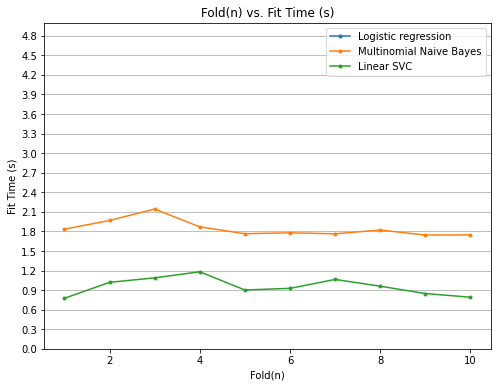

In [44]:
label = ['Acurácia', 'Acurácia Balanceada', 'Área sobre curva ROC']

plt.figure(num=None, figsize=(8, 6))
plt.plot(kfolds, Logistic_Regression, '.', label='Logistic regression',linestyle='-')  # Recebe dois arrays, um sera do K e outro dos resultados
plt.plot(kfolds, Multinomial_Naive_Bayes, '.', label='Multinomial Naive Bayes', linestyle='-')
plt.plot(kfolds, Linear_SVC, '.', label='Linear SVC', linestyle='-')
plt.ylim(0, 5)
plt.yticks(np.arange(0, 5, step=0.3))
#plt.ylim((0,0.6))
plt.xlabel("Fold(n)")
plt.ylabel("Fit Time (s)")
plt.title("Fold(n) vs. Fit Time (s)")
plt.legend()
plt.grid(axis='y')
plt.savefig('graficos/Fit-Time.png')

In [76]:
# Open a file and use dump()
with open('modelo_Logistic_Regression.pkl', 'wb') as file:
    pickle.dump(modelos['Logistic Regression'], file)

In [77]:
    # Open the file in binary mode
    with open('modelo_Logistic_Regression.pkl', 'rb') as file:
        modelo_Logistic_Regression = pickle.load(file)


In [95]:
input_example = 'putos'

input_example = clean_text(input_example)
print (input_example)

input_predict = vectorizer.transform([input_example])
print(input_predict.toarray())


putos
[[0 0 0 ... 0 0 0]]


In [96]:
result = modelo_Logistic_Regression.predict(input_predict.toarray())

In [97]:
print(result[0])

no
